In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, SimpleRNN, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
# ---- PARAMETERS ----
FS            = 50        # sampling freq (Hz)
WINDOW_SZ     = 50        # window size (samples ≈1s)
EPOCHS        = 100
BATCH_SIZE    = 64
PLOT_DURATION = 10        # seconds to plot

# Filepaths for each walking speed
DATA_FILES = {
    "fastest": "Project/imu_data_fastest_speed.csv",
    "medium":  "Project/imu_data_medium_speed.csv",
    "slowest": "Project/imu_data_slowest_speed.csv"
}

### Loading IMU Data

In [ ]:
def load_imu_data(path):
    return pd.read_csv(path)

### Quaternion to Pitch Conversion

In [ ]:
def quaternion_to_pitch(w, x, y, z):
    t2 = 2.0 * (w*y - x*z)
    t5 = w*w - x*x - y*y + z*z
    return np.degrees(np.arctan2(t2, t5))

### Visualize Data

In [ ]:
def plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix):
    mask = times <= PLOT_DURATION
    mask2 = times2 <= PLOT_DURATION
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].plot(times[mask], df['pitch1_sm'][mask], label='Thigh Pitch (sm)')
    ax[0].plot(times[mask], df['pitch2_sm'][mask], label='Shin Pitch (sm)')
    for t in times[minima_idx]:
        if t <= PLOT_DURATION:
            ax[0].axvline(t, color='k', ls='--', alpha=0.6)
    ax[0].set_title(f"Pitch & Toe-offs (0-{PLOT_DURATION}s)")
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Pitch (°)')
    ax[0].legend()

    ax[1].plot(times[mask], df['omega1'][mask], label='Thigh ω (°/s)')
    ax[1].plot(times[mask], df['omega2'][mask], label='Shin ω (°/s)')
    ax[1].set_title(f"Angular Velocity (0-{PLOT_DURATION}s)")
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular velocity (°/s)')
    ax[1].legend()

    ax[2].plot(times2[mask2], df2['t_toeoff'][mask2])
    ax[2].set_title(f"Time-to-Toe-off vs Time (0-{PLOT_DURATION}s)")
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Seconds to Next Toe-off')

    ax[3].hist(df2['t_toeoff'], bins=50)
    ax[3].set_title(f"Time-to-Toe-off Distribution")
    ax[3].set_xlabel('Time to Toe-off (s)')
    ax[3].set_ylabel('Count')

    fig.suptitle(f"{title_prefix.upper()}")

    return fig

### Detect Toe-offs

In [ ]:
pitch_plots = {}

def detect_and_plot_toeoffs(df, fs=FS, title_prefix=""):

    # compute raw & smoothed pitch
    df['pitch1'] = quaternion_to_pitch(df.QuatW,  df.QuatX,  df.QuatY,  df.QuatZ)
    df['pitch2'] = quaternion_to_pitch(df.QuatW2, df.QuatX2, df.QuatY2, df.QuatZ2)
    for c in ['pitch1','pitch2']:
        df[f'{c}_sm'] = (df[c]
                         .rolling(window=5, center=True)
                         .mean()
                         .fillna(method='bfill')
                         .fillna(method='ffill'))
    # compute angular velocities ω
    df['omega1'] = df['pitch1_sm'].diff().fillna(0) * fs
    df['omega2'] = df['pitch2_sm'].diff().fillna(0) * fs

    # time vector
    N     = len(df)
    times = np.arange(N) / fs

    # detect thigh-minima toe-offs AND only those below -100°
    minima_idx, _ = find_peaks(-df['pitch1_sm'].values, distance=int(0.3*fs))
    # filter to pitch1_sm[minima] < -100
    valid_minima = [i for i in minima_idx if df['pitch1_sm'].iloc[i] < -110]
    if len(valid_minima) < 2:
        raise RuntimeError(f"Too few thigh minima <-100° in {title_prefix}")
    minima_idx = np.array(valid_minima)

    # label time-to-toe-off
    next_toe = np.searchsorted(minima_idx, np.arange(N), side='right')
    valid    = next_toe < len(minima_idx)
    df2      = df.iloc[valid].reset_index(drop=True)
    times2   = times[valid]
    thigh_times = times[minima_idx]
    df2['t_toeoff'] = thigh_times[next_toe[valid]] - times2

    fig = plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix)

    pitch_plots[title_prefix] = fig

    return df2

### Making Dataset

In [ ]:
def make_dataset(df2):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ','AccX','AccY','AccZ','GyroX','GyroY','GyroZ',
                    'QuatW2','QuatX2','QuatY2','QuatZ2','AccX2','AccY2','AccZ2','GyroX2','GyroY2','GyroZ2']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    return X, y

### Machine Learning Approach

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db827429

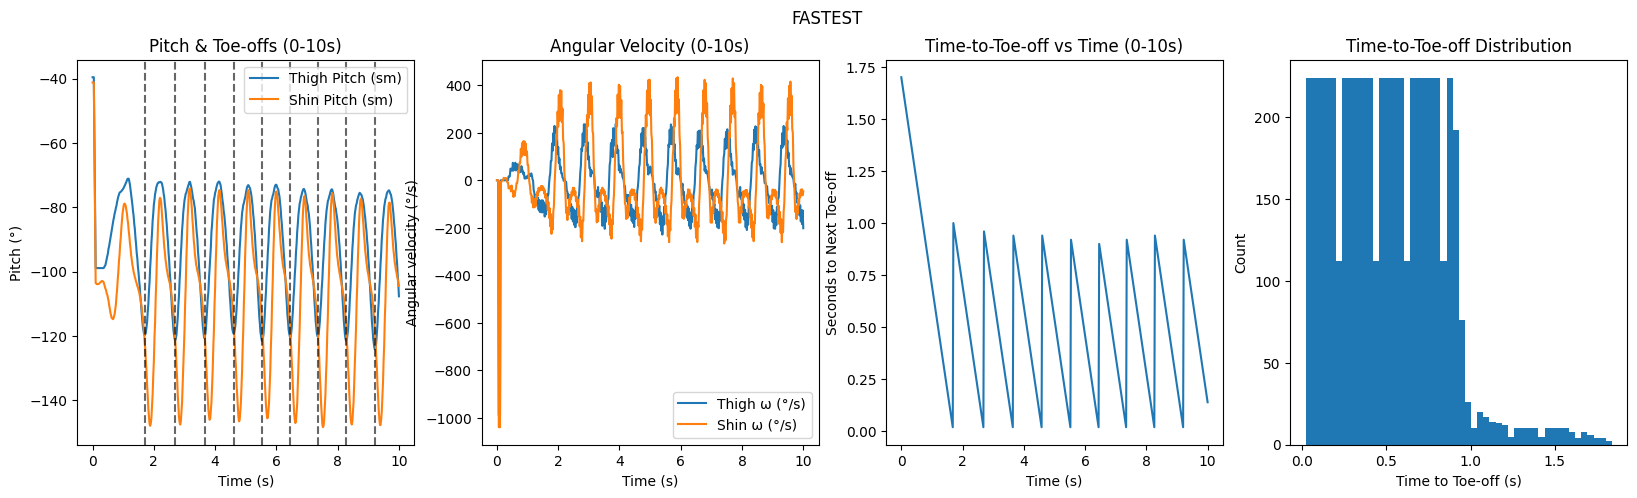

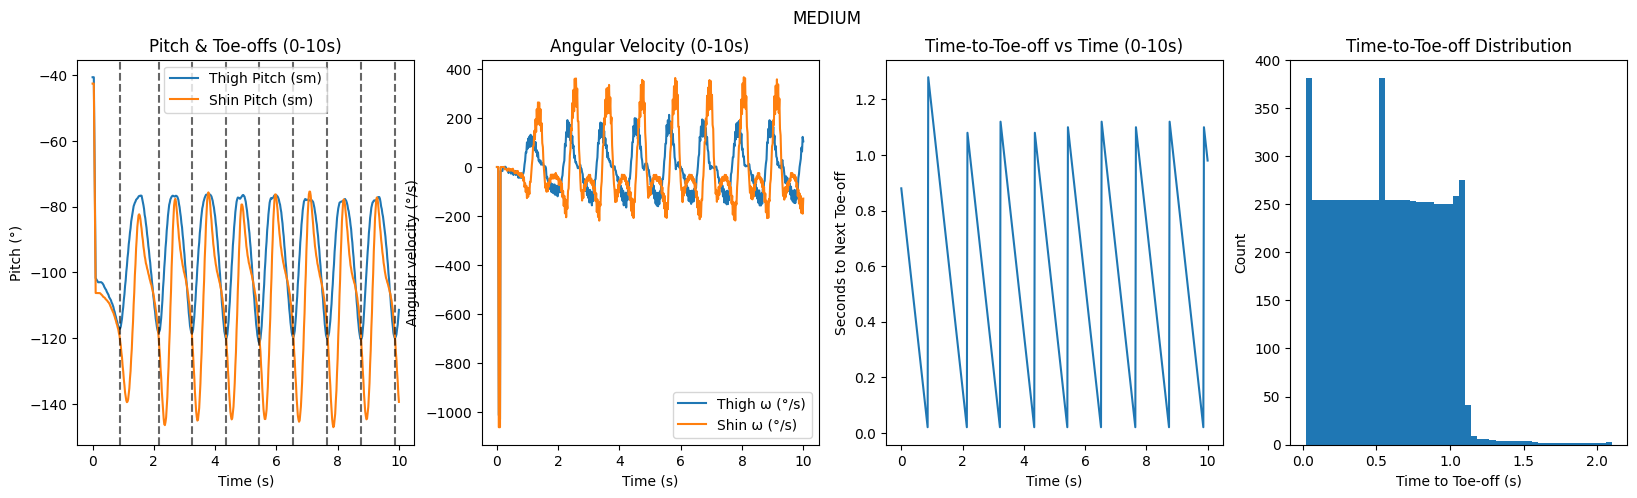

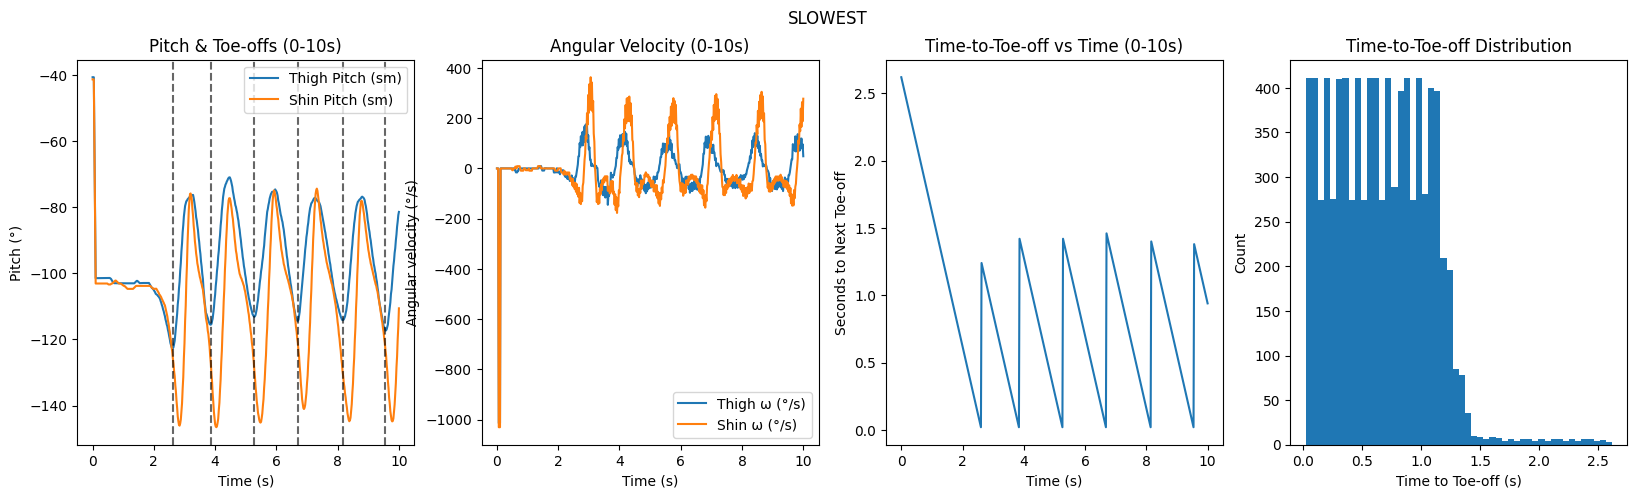

In [ ]:
X_all_temp = []
y_all_temp = []

for name, path in DATA_FILES.items():
    df    = load_imu_data(path)
    df2   = detect_and_plot_toeoffs(df, title_prefix=name.capitalize())
    X, y  = make_dataset(df2)

    X_all_temp.append(X)
    y_all_temp.append(y)

X_all = np.concatenate([X_all_temp[i] for i in range(len(X_all_temp))], axis=0)
y_all = np.concatenate([y_all_temp[i] for i in range(len(y_all_temp))], axis=0)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2)
y_train_all = y_train_all.reshape(y_train_all.shape[0], -1)
y_test_all = y_test_all.reshape(y_test_all.shape[0], -1)

input_shape = (WINDOW_SZ, X_train_all.shape[2])

In [ ]:
print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)

(16744, 50, 20) (4187, 50, 20) (16744, 1) (4187, 1)


In [ ]:
EPOCHS = 10
lrs = [1e-5, 1e-4, 1e-3, 1e-2]
hids = [32, 64, 128]
rnn_maes = np.zeros((len(hids), len(lrs)))

loss = 'mse'
metrics = ['mae']

es = tf.keras.callbacks.EarlyStopping('val_mae', patience=5, restore_best_weights=True, verbose=0)

for i, H in enumerate(hids):
    h1 = H
    h2 = int(0.5*h1)
    h3 = int(0.25*h1)
    for j, lr in enumerate(lrs):
        optimizer = Adam(learning_rate=lr)
        model = Sequential([
            SimpleRNN(h1, return_sequences=True, input_shape=input_shape),
            SimpleRNN(h2),
            Dense(h3, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        h = model.fit(X_train_all, y_train_all,
                            validation_data=(X_test_all, y_test_all),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
        l, mae = model.evaluate(X_test_all, y_test_all, verbose=0, callbacks=[es])
        print(f"Combined val MAE = {mae:.3f} for RNN")

        rnn_maes[i,j] = min(h.history['val_mae'])

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 1.6332 - mae: 1.1461 - val_loss: 1.4440 - val_mae: 1.0877
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1.3878 - mae: 1.0617 - val_loss: 1.2776 - val_mae: 1.0266
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 1.2223 - mae: 0.9996 - val_loss: 1.1480 - val_mae: 0.9743
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 1.1196 - mae: 0.9577 - val_loss: 1.0454 - val_mae: 0.9293
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.0065 - mae: 0.9060 - val_loss: 0.9611 - val_mae: 0.8894
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.9234 - mae: 0.8654 - val_loss: 0.8905 - val_mae: 0.8537
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.8595 - mae: 0.8329 - val_loss: 0.8302 - val_mae: 0.8213
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.8062 - mae: 0.8052 - val_loss: 0.7783 - val_mae: 0.7918
Epoch 9/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 

In [ ]:
gru_maes = np.zeros((len(hids), len(lrs)))

loss = 'mse'
metrics = ['mae']

es = tf.keras.callbacks.EarlyStopping('val_mae', patience=5, restore_best_weights=True, verbose=0)

for i, H in enumerate(hids):
    h1 = H
    h2 = int(0.5*h1)
    h3 = int(0.25*h1)
    for j, lr in enumerate(lrs):
        optimizer = Adam(learning_rate=lr)
        model = Sequential([
            GRU(h1, return_sequences=True, input_shape=input_shape),
            GRU(h2),
            Dense(h3, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        h = model.fit(X_train_all, y_train_all,
                            validation_data=(X_test_all, y_test_all),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[es])
        l, mae = model.evaluate(X_test_all, y_test_all, verbose=0)
        print(f"Combined val MAE = {mae:.3f} for GRU")

        gru_maes[i,j] = min(h.history['val_mae'])

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 0.4857 - mae: 0.5942 - val_loss: 0.4358 - val_mae: 0.5593
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.4040 - mae: 0.5347 - val_loss: 0.3646 - val_mae: 0.5047
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.3403 - mae: 0.4839 - val_loss: 0.3103 - val_mae: 0.4607
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 0.2878 - mae: 0.4401 - val_loss: 0.2680 - val_mae: 0.4241
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 0.2471 - mae: 0.4057 - val_loss: 0.2343 - val_mae: 0.3930
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - loss: 0.2224 - mae: 0.3807 - val_loss: 0.2074 - val_mae: 0.3670
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 0.1965 - mae: 0.3553 - val_loss: 0.1858 - val_mae: 0.3445
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.1768 - mae: 0.3340 - val_loss: 0.1682 - val_mae: 0.3251
Epoch 9/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 

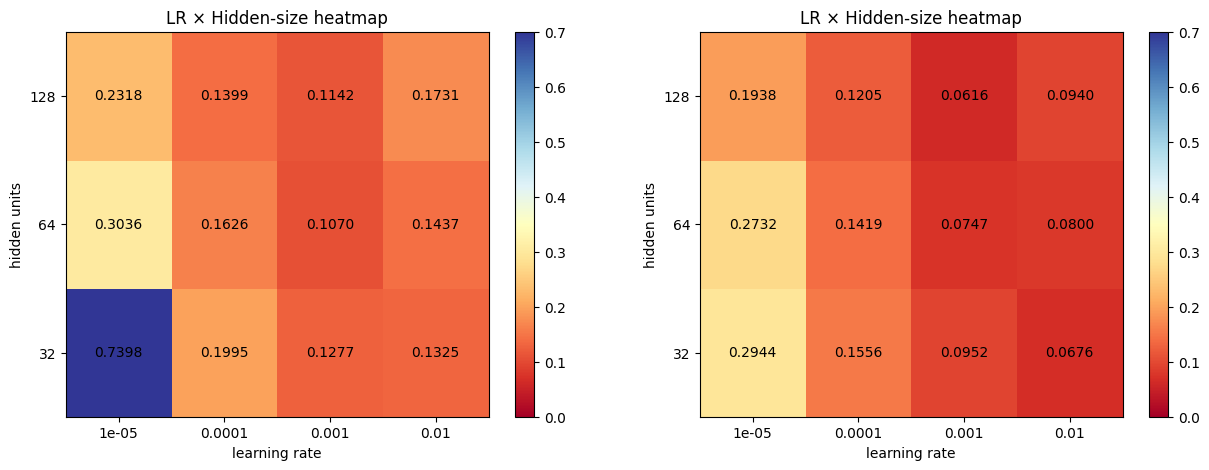

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

mat = ax[0].imshow(rnn_maes, aspect='auto', origin='lower', cmap='RdYlBu', vmin=0, vmax=0.7)
plt.colorbar(mat)
ax[0].set_xticks(range(len(lrs)), lrs)
ax[0].set_yticks(range(len(hids)), hids)
ax[0].set_xlabel('learning rate')
ax[0].set_ylabel('hidden units')
ax[0].set_title('LR × Hidden‐size heatmap')

mat = ax[1].imshow(gru_maes, aspect='auto', origin='lower', cmap='RdYlBu', vmin=0, vmax=0.7)
plt.colorbar(mat)
ax[1].set_xticks(range(len(lrs)), lrs)
ax[1].set_yticks(range(len(hids)), hids)
ax[1].set_xlabel('learning rate')
ax[1].set_ylabel('hidden units')
ax[1].set_title('LR × Hidden‐size heatmap')

for j in range(len(lrs)):
    for i in range(len(hids)):
        rnn = rnn_maes[i, j]
        gru = gru_maes[i, j]
        ax[0].text(j, i, f"{rnn:.4f}", va='center', ha='center')
        ax[1].text(j, i, f"{gru:.4f}", va='center', ha='center')

plt.show()